# Análisis de métricas de la blockchain

Las métricas son cargadas a través de la API pública de Coinmetrics, se eliminan posibles valores atípicos multivariados usando la distancia de Mahalanovis, con análisis de regresión multiple se seleccionan aquellas con mayor significacia estadistica, se toman aquellas variables con mejor expliquen la varianza del precio y compara con un dendograma de correlación.

## Librerias
La API de coinmetrics es utilizada para descargar los datos en linea actualizados, pandas para operar sobre los dataframes, sklearn para realizar PCA y scipy para el agrupamiento jerarquico y análisis de regresión.


In [1]:
import coinmetrics
import numpy as np
import datetime as dt
import pandas as pd
import time
from sklearn.decomposition import PCA
from pca import pca
from sklearn import preprocessing
from scipy import stats
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)


## Carga de métricas desde la API

Descarga de caracteristicas disponibles de la blockchain a traves de API usando coinmetrics

In [ ]:
cm = coinmetrics.Community()
moneda = 'btc'
available_data_types = cm.get_available_data_types_for_asset(moneda)

#Métricas totales disponibles para la moneda.
metrica = "AdrActCnt,BlkCnt,BlkSizeByte,BlkSizeMeanByte,CapMVRVCur,CapMrktCurUSD,CapRealUSD,DiffMean,FeeMeanNtv,\
FeeMeanUSD,FeeMedNtv,FeeMedUSD,FeeTotNtv,FeeTotUSD,HashRate,IssContNtv,IssContPctAnn,IssContUSD,IssTotNtv,IssTotUSD,\
NVTAdj,NVTAdj90,PriceBTC,PriceUSD,ROI1yr,ROI30d,SplyCur,SplyExpFut10yrCMBI,SplyFF,TxCnt,TxTfrCnt,TxTfrValAdjNtv,\
TxTfrValAdjUSD,TxTfrValMeanNtv,TxTfrValMeanUSD,TxTfrValMedNtv,TxTfrValMedUSD,TxTfrValUSD,VtyDayRet180d,\
VtyDayRet30d"

#Métricas usadas para análisis final.
#metrica = "AdrActCnt,CapMrktCurUSD,DiffMean,PriceUSD,\
#FeeTotNtv,SplyCur,SplyFF,TxTfrCnt,TxTfrValMeanUSD,TxTfrValUSD,VtyDayRet30d"

begin_timestamp = "2012-02-02"
end_timestamp = '2021-08-11'
asset_data = cm.get_asset_data_for_time_range(moneda, metrica ,begin_timestamp, end_timestamp)

In [6]:
# Convertir de Coin Metrics a dataframe solo si se descarga con la API
#btc = coinmetrics.cm_to_pandas(asset_data)
#btc.index = np.arange(len(btc))

## Carga de métricas desde CSV
Carga de 139 métricas descargadas directamente de coinmetrics en formato CSV

In [2]:
btc = pd.read_csv('/Users/sacbe/Documents/Tesis licenciatura/Algoritmos/cleaning/BTC - coinMetrics_Abril_2022.csv', sep = ',')
#for column in btc.columns:
#    print(column)

In [3]:
btc.info()
btc = btc[btc.time > '2012-02-02']
btc = btc.set_index('time')
btc.index = pd.to_datetime(btc.index)

#btc = btc[['AdrActCnt','BlkCnt','BlkSizeMeanByte','CapMVRVCur','CapMrktCurUSD','CapRealUSD','DiffMean','FeeMeanNtv','FeeMeanUSD','FeeMedNtv','FeeMedUSD','FeeTotNtv','FeeTotUSD','HashRate','IssContNtv','IssContPctAnn','IssContUSD','IssTotNtv','IssTotUSD','NVTAdj','NVTAdj90','PriceBTC',"PriceUSD",'ROI1yr','ROI30d','SplyCur','SplyExpFut10yr','SplyFF','TxCnt','TxTfrCnt','TxTfrValAdjNtv','TxTfrValAdjUSD','TxTfrValMeanNtv','TxTfrValMeanUSD','TxTfrValMedNtv','TxTfrValMedUSD','VtyDayRet180d','VtyDayRet30d']]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4851 entries, 0 to 4850
Columns: 144 entries, time to VtyDayRet30d
dtypes: float64(115), int64(28), object(1)
memory usage: 5.3+ MB


In [4]:
display(btc)

,AdrActCnt,AdrBal1in100KCnt,AdrBal1in100MCnt,AdrBal1in10BCnt,AdrBal1in10KCnt,AdrBal1in10MCnt,AdrBal1in1BCnt,AdrBal1in1KCnt,AdrBal1in1MCnt,AdrBalCnt,...,TxTfrCnt,TxTfrValAdjNtv,TxTfrValAdjUSD,TxTfrValMeanNtv,TxTfrValMeanUSD,TxTfrValMedNtv,TxTfrValMedUSD,VelCur1yr,VtyDayRet180d,VtyDayRet30d
time,,,,,,,,,,,,,,,,,,,,,
2012-02-03,17088,8493,165725,290241,912,127794,250654,84,76313,582504,...,15601,162689.307436,9.682635e+05,20.106052,119.663396,0.766127,4.559687,36.208762,0.076967,0.071134
2012-02-04,16038,8475,165736,290349,915,127569,250747,84,76054,582588,...,14257,179581.635749,1.058708e+06,20.381133,120.155200,0.793341,4.677072,36.202880,0.076691,0.059628
2012-02-05,14720,8475,166030,290785,922,127732,251082,85,76105,582938,...,13498,140335.863300,7.968433e+05,21.591761,122.600519,0.895272,5.083455,36.197119,0.074717,0.059778
2012-02-06,14174,8492,166181,291134,921,127740,251329,85,76045,583234,...,12197,164096.820935,8.996877e+05,22.181705,121.614837,1.000000,5.482664,36.190390,0.074725,0.059863
2012-02-07,14474,8501,166171,291422,923,127713,251497,85,76137,583526,...,13634,148054.506042,8.382887e+05,18.426511,104.331415,0.864454,4.894564,36.172102,0.074638,0.059575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-11,986075,9320,2345050,16989948,970,476970,7272721,45,98531,41629314,...,852206,643379.730791,2.544182e+10,1.852088,73239.002247,0.002326,91.965562,15.706794,0.033288,0.027041
2022-04-12,970523,9322,2345957,16993720,975,477067,7278066,45,98540,41601479,...,807070,713960.647444,2.862723e+10,2.063615,82743.455681,0.002425,97.234893,15.761115,0.033309,0.026525
2022-04-13,960119,9322,2346556,17009961,973,477002,7284594,46,98519,41631780,...,848908,812339.045048,3.342999e+10,2.368099,97453.782285,0.002388,98.264961,15.826344,0.032957,0.025522


### Revisión de NANs

In [5]:
print(btc.isnull().values.any())
print(btc.isnull().sum().sum())

True
1283


## Inputación de datos faltantes para eliminación de posibles NANs    


In [6]:
db = btc.interpolate(method = 'time' ,limit_direction= "both")
db.tail()

,AdrActCnt,AdrBal1in100KCnt,AdrBal1in100MCnt,AdrBal1in10BCnt,AdrBal1in10KCnt,AdrBal1in10MCnt,AdrBal1in1BCnt,AdrBal1in1KCnt,AdrBal1in1MCnt,AdrBalCnt,...,TxTfrCnt,TxTfrValAdjNtv,TxTfrValAdjUSD,TxTfrValMeanNtv,TxTfrValMeanUSD,TxTfrValMedNtv,TxTfrValMedUSD,VelCur1yr,VtyDayRet180d,VtyDayRet30d
time,,,,,,,,,,,,,,,,,,,,,
2022-04-11,986075,9320,2345050,16989948,970,476970,7272721,45,98531,41629314,...,852206,643379.730791,2.544182e+10,1.852088,73239.002247,0.002326,91.965562,15.706794,0.033288,0.027041
2022-04-12,970523,9322,2345957,16993720,975,477067,7278066,45,98540,41601479,...,807070,713960.647444,2.862723e+10,2.063615,82743.455681,0.002425,97.234893,15.761115,0.033309,0.026525
2022-04-13,960119,9322,2346556,17009961,973,477002,7284594,46,98519,41631780,...,848908,812339.045048,3.342999e+10,2.368099,97453.782285,0.002388,98.264961,15.826344,0.032957,0.025522
2022-04-14,910470,9341,2347542,17025461,969,477221,7289867,46,98512,41667344,...,802191,780070.754587,3.113769e+10,2.364487,94382.026811,0.002416,96.434264,15.887006,0.033021,0.026132
2022-04-15,893942,9346,2348189,17045632,967,477366,7291583,45,98477,41736539,...,819141,500845.712056,2.029794e+10,1.493274,60518.390924,0.002300,93.212864,15.918760,0.033037,0.025019


In [7]:
print(db.isnull().values.any())
print(db.isnull().sum().sum())

False
0


In [8]:
db = db.loc[:, (db != 0).any(axis=0)]
db = db.loc[:, db.columns != "PriceBTC"]

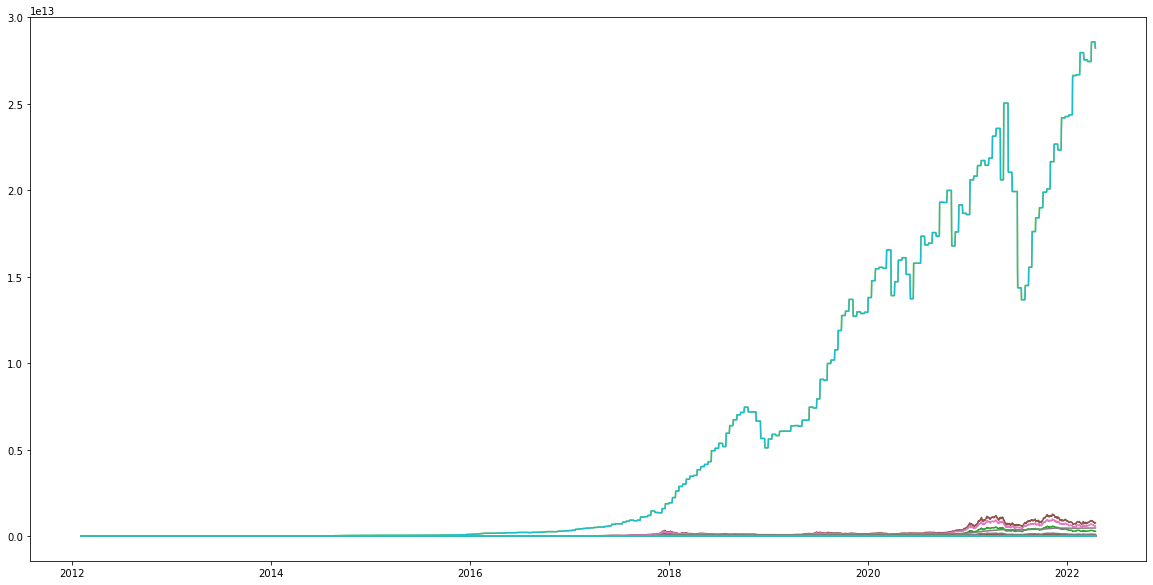

In [9]:
plt.plot(db)
plt.show()

Dataframe con valores atípicos exremos

In [10]:
df_with_out = pd.DataFrame(db.values)
df_with_out.columns = db.columns
df_with_out.tail(5)    

,AdrActCnt,AdrBal1in100KCnt,AdrBal1in100MCnt,AdrBal1in10BCnt,AdrBal1in10KCnt,AdrBal1in10MCnt,AdrBal1in1BCnt,AdrBal1in1KCnt,AdrBal1in1MCnt,AdrBalCnt,...,TxTfrCnt,TxTfrValAdjNtv,TxTfrValAdjUSD,TxTfrValMeanNtv,TxTfrValMeanUSD,TxTfrValMedNtv,TxTfrValMedUSD,VelCur1yr,VtyDayRet180d,VtyDayRet30d
3720,986075.0,9320.0,2345050.0,16989948.0,970.0,476970.0,7272721.0,45.0,98531.0,41629314.0,...,852206.0,643379.730791,2.544182e+10,1.852088,73239.002247,0.002326,91.965562,15.706794,0.033288,0.027041
3721,970523.0,9322.0,2345957.0,16993720.0,975.0,477067.0,7278066.0,45.0,98540.0,41601479.0,...,807070.0,713960.647444,2.862723e+10,2.063615,82743.455681,0.002425,97.234893,15.761115,0.033309,0.026525
3722,960119.0,9322.0,2346556.0,17009961.0,973.0,477002.0,7284594.0,46.0,98519.0,41631780.0,...,848908.0,812339.045048,3.342999e+10,2.368099,97453.782285,0.002388,98.264961,15.826344,0.032957,0.025522
3723,910470.0,9341.0,2347542.0,17025461.0,969.0,477221.0,7289867.0,46.0,98512.0,41667344.0,...,802191.0,780070.754587,3.113769e+10,2.364487,94382.026811,0.002416,96.434264,15.887006,0.033021,0.026132
3724,893942.0,9346.0,2348189.0,17045632.0,967.0,477366.0,7291583.0,45.0,98477.0,41736539.0,...,819141.0,500845.712056,2.029794e+10,1.493274,60518.390924,0.002300,93.212864,15.918760,0.033037,0.025019


## Eliminación de outliers multivariados

Se crea una función de detección de valores atípicos con la regla de detección de dos veces la media de los datos con la distancia de Mahalanovis.

In [11]:
df = pd.DataFrame(db.values)
df.columns = db.columns
df.tail(5)    

,AdrActCnt,AdrBal1in100KCnt,AdrBal1in100MCnt,AdrBal1in10BCnt,AdrBal1in10KCnt,AdrBal1in10MCnt,AdrBal1in1BCnt,AdrBal1in1KCnt,AdrBal1in1MCnt,AdrBalCnt,...,TxTfrCnt,TxTfrValAdjNtv,TxTfrValAdjUSD,TxTfrValMeanNtv,TxTfrValMeanUSD,TxTfrValMedNtv,TxTfrValMedUSD,VelCur1yr,VtyDayRet180d,VtyDayRet30d
3720,986075.0,9320.0,2345050.0,16989948.0,970.0,476970.0,7272721.0,45.0,98531.0,41629314.0,...,852206.0,643379.730791,2.544182e+10,1.852088,73239.002247,0.002326,91.965562,15.706794,0.033288,0.027041
3721,970523.0,9322.0,2345957.0,16993720.0,975.0,477067.0,7278066.0,45.0,98540.0,41601479.0,...,807070.0,713960.647444,2.862723e+10,2.063615,82743.455681,0.002425,97.234893,15.761115,0.033309,0.026525
3722,960119.0,9322.0,2346556.0,17009961.0,973.0,477002.0,7284594.0,46.0,98519.0,41631780.0,...,848908.0,812339.045048,3.342999e+10,2.368099,97453.782285,0.002388,98.264961,15.826344,0.032957,0.025522
3723,910470.0,9341.0,2347542.0,17025461.0,969.0,477221.0,7289867.0,46.0,98512.0,41667344.0,...,802191.0,780070.754587,3.113769e+10,2.364487,94382.026811,0.002416,96.434264,15.887006,0.033021,0.026132
3724,893942.0,9346.0,2348189.0,17045632.0,967.0,477366.0,7291583.0,45.0,98477.0,41736539.0,...,819141.0,500845.712056,2.029794e+10,1.493274,60518.390924,0.002300,93.212864,15.918760,0.033037,0.025019


In [12]:
from sklearn.covariance import EmpiricalCovariance, MinCovDet

def m_detectOutliers(data, extreme=False):
    robust_cov = MinCovDet(support_fraction=1.0).fit(data)
    #robust_cov = EmpiricalCovariance().fit(data)
    m = robust_cov.mahalanobis(data)
    # print(m)
    me = np.mean(m)
    t = 3. * me if extreme else 2. * me
    outliers = []
    for i in range(len(m)):
        if m[i] > t:
            outliers.append(i)
    return np.array(outliers)

df_wo = df.drop(m_detectOutliers(df, extreme = True))

/opt/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_robust_covariance.py:647: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "


La matriz de covarianza no tiene rango completo ya que algunas variables de la blockchain son combinación lineal de otras, por ejemplo:

$CapMrktCurUSD = SplyCur * PriceUSD$

## Normalización de datos


In [13]:
x = df_wo.values
y = df_with_out.values

#x = df_regresion_wo.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
y_scaled = min_max_scaler.fit_transform(y)

df = pd.DataFrame(x_scaled)
df.columns = df_wo.columns

df_with_out = pd.DataFrame(y_scaled)
df_with_out.columns = df_wo.columns
#df.columns = df_regresion_wo.columns

### Dataframe con outliers univariados y multivariados usado para comparación en PCA

Gráfica con las primeras cinco columnas normalizadas del conjunto de datos sin valores atípicos extremos

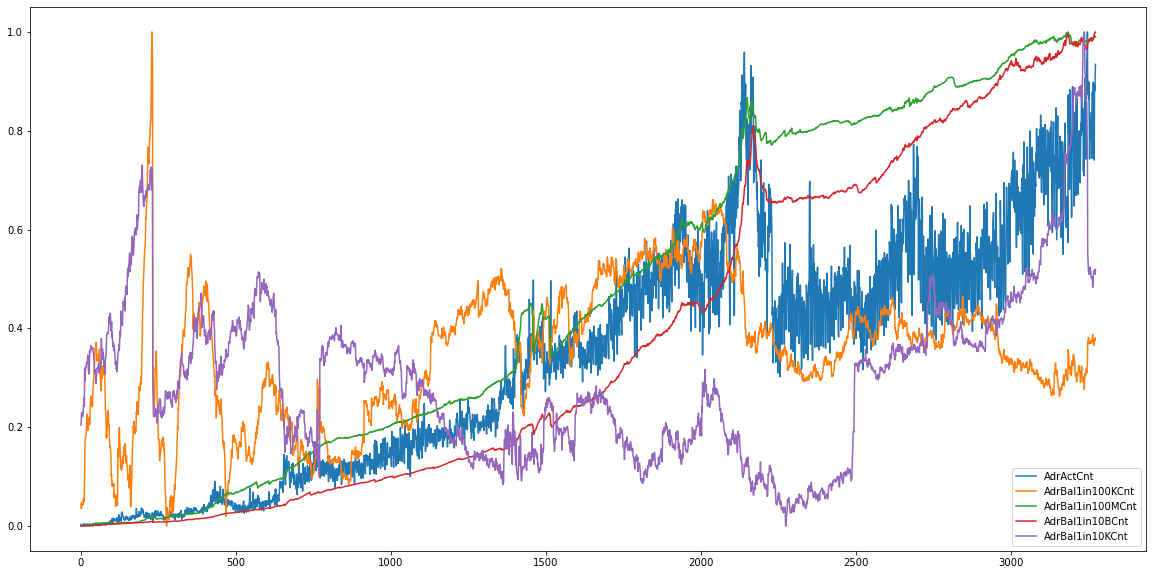

,AdrActCnt,AdrBal1in100KCnt,AdrBal1in100MCnt,AdrBal1in10BCnt,AdrBal1in10KCnt,AdrBal1in10MCnt,AdrBal1in1BCnt,AdrBal1in1KCnt,AdrBal1in1MCnt,AdrBalCnt,...,TxTfrCnt,TxTfrValAdjNtv,TxTfrValAdjUSD,TxTfrValMeanNtv,TxTfrValMeanUSD,TxTfrValMedNtv,TxTfrValMedUSD,VelCur1yr,VtyDayRet180d,VtyDayRet30d
3270,0.740634,0.374875,0.989073,0.994916,0.516827,0.987565,0.986715,0.087719,0.727427,0.992445,...,0.420385,0.164998,0.720945,0.000632,0.437146,0.004877,0.313824,0.000949,0.211535,0.258890
3271,0.892909,0.373878,0.990107,0.996240,0.519231,0.987930,0.988235,0.087719,0.726231,0.994504,...,0.499935,0.126962,0.632820,0.000275,0.345290,0.004471,0.305136,0.000639,0.214783,0.262059
3272,0.881532,0.378863,0.991407,0.998575,0.514423,0.988175,0.990391,0.105263,0.723172,0.997096,...,0.484828,0.131751,0.685560,0.000314,0.378203,0.004291,0.309148,0.000582,0.216949,0.262230
3273,0.911291,0.376869,0.989720,1.000000,0.509615,0.987488,0.989084,0.105263,0.721309,0.999548,...,0.517875,0.180310,0.852650,0.000543,0.452738,0.004609,0.328102,0.000664,0.217308,0.255958
3274,0.934393,0.380359,0.990381,0.999180,0.519231,0.988014,0.988811,0.087719,0.721226,1.000000,...,0.502638,0.165454,0.818743,0.000504,0.450329,0.003846,0.280661,0.000360,0.217519,0.247718


In [14]:
plt.plot(df.iloc[ : , :5])
plt.legend(df.iloc[ : , :5])
plt.show()
df.tail(5)

Gráfica con las primeras cinco columnas normalizadas del conjunto de datos con valores atípicos extremos

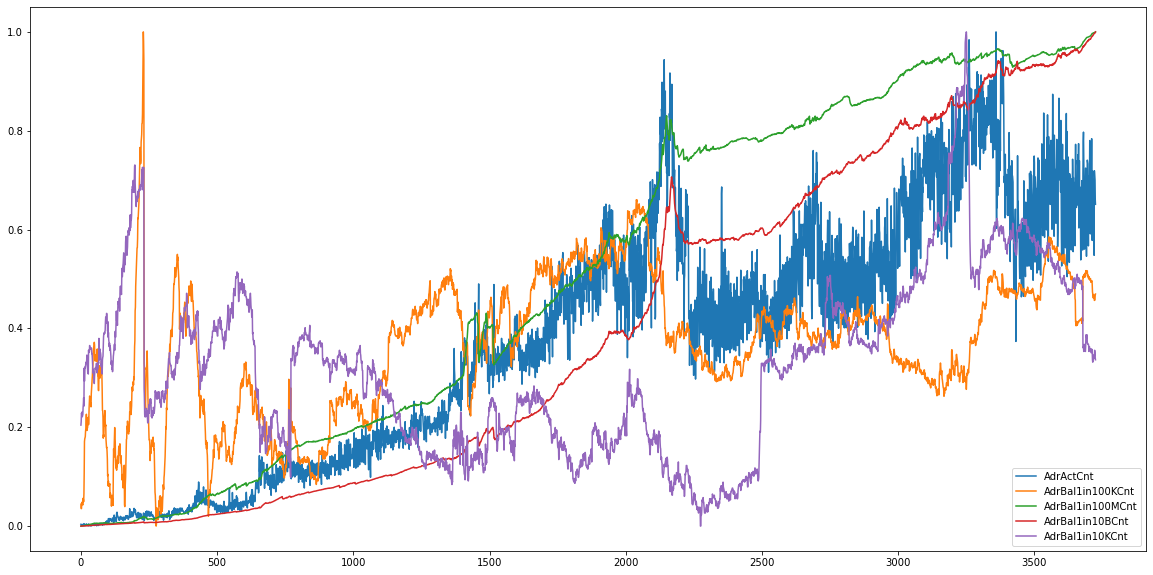

,AdrActCnt,AdrBal1in100KCnt,AdrBal1in100MCnt,AdrBal1in10BCnt,AdrBal1in10KCnt,AdrBal1in10MCnt,AdrBal1in1BCnt,AdrBal1in1KCnt,AdrBal1in1MCnt,AdrBalCnt,...,TxTfrCnt,TxTfrValAdjNtv,TxTfrValAdjUSD,TxTfrValMeanNtv,TxTfrValMeanUSD,TxTfrValMedNtv,TxTfrValMedUSD,VelCur1yr,VtyDayRet180d,VtyDayRet30d
3720,0.719132,0.456630,0.998562,0.996677,0.343750,0.952633,0.997321,0.140351,0.625289,0.997395,...,0.414252,0.452931,0.697684,0.003256,0.144584,0.002263,0.171942,0.060855,0.190468,0.106169
3721,0.707650,0.457627,0.998977,0.996902,0.355769,0.952897,0.998080,0.140351,0.625539,0.996718,...,0.392025,0.508752,0.785038,0.003702,0.163363,0.002360,0.181794,0.061529,0.190770,0.103367
3722,0.699968,0.457627,0.999252,0.997871,0.350962,0.952720,0.999007,0.157895,0.624955,0.997454,...,0.412628,0.586558,0.916746,0.004344,0.192429,0.002324,0.183720,0.062338,0.185603,0.097920
3723,0.663312,0.467099,0.999704,0.998796,0.341346,0.953317,0.999756,0.157895,0.624760,0.998319,...,0.389622,0.561038,0.853884,0.004336,0.186359,0.002351,0.180297,0.063090,0.186545,0.101236
3724,0.651109,0.469591,1.000000,1.000000,0.336538,0.953713,1.000000,0.140351,0.623787,1.000000,...,0.397970,0.340204,0.556622,0.002500,0.119450,0.002238,0.174274,0.063484,0.186775,0.095194


In [15]:
plt.plot(df_with_out.iloc[ : , :5])
plt.legend(df_with_out.iloc[ : , :5])
plt.show()
df_with_out.tail(5)

## Análisis de regresión multiple

In [16]:

from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

#Con todas las métricas menos el precio
X = df.loc[:, df.columns != 'PriceUSD']
y = df["PriceUSD"]

#X_train, X_test, y_train, y_test = train_test_split(X, y.values.reshape(-1,1), test_size = 0.0, shuffle=False)

### Eliminación de multicollinearity

In [17]:
corr_df = X.corr(method='pearson')
corr_df = pd.DataFrame(corr_df)
high_corr = corr_df[abs(corr_df) > 0.9]
#high_corr.drop(["const"], axis=0, inplace=True)
#high_corr.drop(["const"], axis=1, inplace=True)

for name in high_corr.columns:
    if (high_corr[name].isnull().sum().sum()) == (len(high_corr.index)-1):
        high_corr.drop([name], axis=0, inplace=True)
        high_corr.drop([name], axis=1, inplace=True)

display(high_corr.columns)

Index(['AdrActCnt', 'AdrBal1in100MCnt', 'AdrBal1in10BCnt', 'AdrBal1in10MCnt',
       'AdrBal1in1BCnt', 'AdrBal1in1MCnt', 'AdrBalCnt', 'AdrBalNtv0.001Cnt',
       'AdrBalNtv0.01Cnt', 'AdrBalNtv0.1Cnt',
       ...
       'SplyCur', 'SplyExpFut10yr', 'SplyFF', 'SplyMiner0HopAllNtv',
       'SplyMiner0HopAllUSD', 'SplyMiner1HopAllUSD', 'TxCnt', 'TxCntSec',
       'TxTfrCnt', 'TxTfrValAdjUSD'],
      dtype='object', length=108)

In [18]:
data_high_corr = pd.DataFrame(data=X, columns = high_corr.columns)

### Calculo de VIF

In [19]:
# Función que calcula VIF (Variance Inflation Factor)
def calculate_vif(data):
    vif_df = pd.DataFrame(columns = ['Var', 'Vif'])
    x_var_names = data.columns
    for i in range(0, x_var_names.shape[0]):
        y = data[x_var_names[i]]
        x = data[x_var_names.drop([x_var_names[i]])]
        r_squared = sm.OLS(y,x).fit().rsquared
        vif = round(1/(1-r_squared),2)
        vif_df.loc[i] = [x_var_names[i], vif]
    return vif_df.sort_values(by = 'Vif', axis = 0, ascending=False, inplace=False)

vif_data = calculate_vif(data_high_corr)
display(vif_data)

,Var,Vif
60,RevHashNtv,inf
63,RevHashUSD,1.501200e+15
62,RevHashRateUSD,4.503600e+14
48,IssContUSD,2.649176e+14
61,RevHashRateNtv,2.134407e+13
...,...,...
107,TxTfrValAdjUSD,6.700000e+01
42,FlowOutExUSD,5.142000e+01
40,FlowInExUSD,5.057000e+01
39,FlowInExNtv,3.111000e+01


In [20]:
vif_data.index = np.arange(0, len(vif_data.index), 1)

In [21]:
#for index in vif_data.index:
index = 0
while(True):
    if vif_data["Vif"][index] > 5:
        print(vif_data["Var"][index])
        data_high_corr.drop([vif_data["Var"][index]], axis=1, inplace=True)
        vif_data = calculate_vif(data_high_corr)
        vif_data.index = np.arange(0, len(vif_data.index), 1)
    else:
        break

display(vif_data)

RevHashNtv
RevHashUSD
IssContNtv
IssTotUSD
IssContPctAnn
TxCntSec
ReferenceRate
SplyAdrBalNtv0.001
SplyAdrBal1in10B
SplyAdrBalNtv0.01
SplyCur
SplyAdrBalNtv0.1
SplyAdrBal1in1B
SplyAdrBalNtv1
SplyAdrBalUSD1
SplyAdrBal1in100M
SplyAdrBalNtv10
SplyAdrBalUSD10
RevUSD
SplyAdrBal1in10M
SplyActEver
SplyAdrBalNtv100
SplyAdrBalUSD100
SplyAdrBal1in1M
SplyAct10yr
AdrBal1in10BCnt
CapMrktFFUSD
SplyAdrTop10Pct
AdrBalNtv0.1Cnt
AssetEODCompletionTime
AdrBalNtv1Cnt
SplyAct5yr
SplyExpFut10yr
SplyAdrTop1Pct
AdrBalNtv0.01Cnt
SplyMiner0HopAllUSD
SplyAdrBalNtv1K
DiffMean
AdrBalNtv0.001Cnt
IssTotNtv
SplyAdrBalUSD100K
AdrBalNtv10Cnt
AdrBal1in100MCnt
SplyAdrBal1in100K
AdrBalUSD10Cnt
CapMVRVCur
AdrBalUSD100Cnt
SplyAct4yr
SplyAdrBalUSD10K
AdrBalUSD1Cnt
AdrBal1in1BCnt
SplyMiner1HopAllUSD
AdrBalUSD10KCnt
SplyFF
ReferenceRateUSD
AdrBal1in10MCnt
SplyAdrBalUSD1K
NVTAdj90
BlkWghtMean
SplyAdrBalUSD10M
RevAllTimeUSD
HashRate30d
SplyAdrBal1in10K
NVTAdj
CapMrktCurUSD
AdrBalUSD1KCnt
SER
SplyAdrBalNtv10K
IssContPctDay
AdrBalN

,Var,Vif
0,AdrBalUSD1MCnt,4.14
1,FeeByteMeanNtv,3.93
2,HashRate,3.69
3,RevHashRateUSD,2.85
4,FeeMedUSD,2.78
5,NVTAdjFF,2.15
6,RevHashRateNtv,2.07
7,FlowInExNtv,1.86


In [22]:
X = pd.DataFrame(data=X, columns = data_high_corr.columns)
display(X)

,AdrBalUSD1MCnt,FeeByteMeanNtv,FeeMedUSD,FlowInExNtv,HashRate,NVTAdjFF,RevHashRateNtv,RevHashRateUSD
0,0.000000,0.205305,0.000000,0.003032,1.073670e-08,0.253234,1.000000e+00,0.299633
1,0.000000,0.245580,0.000000,0.004287,1.218393e-08,0.224451,9.699303e-01,0.287879
2,0.000000,0.131631,0.000000,0.011035,7.693048e-09,0.303073,9.475799e-01,0.270878
3,0.000000,0.148330,0.000000,0.012504,9.261196e-09,0.251410,9.475933e-01,0.261558
4,0.000000,0.203340,0.000000,0.006964,5.732863e-09,0.284956,9.478997e-01,0.270202
...,...,...,...,...,...,...,...,...
3270,0.949420,0.073841,0.249905,0.135445,7.041420e-01,0.261020,8.549720e-10,0.000011
3271,0.968609,0.063851,0.225417,0.131154,9.053254e-01,0.326876,6.685040e-10,0.000012
3272,0.987641,0.060904,0.254540,0.142759,8.875740e-01,0.317124,6.105021e-10,0.000012
3273,0.983546,0.070727,0.261557,0.176756,9.467456e-01,0.240526,7.712621e-10,0.000012


In [23]:
X = sm.add_constant(X, prepend=True)
modelo = sm.OLS(endog=y, exog=X,)
modelo = modelo.fit()
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:               PriceUSD   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                 1.225e+04
Date:                Tue, 19 Apr 2022   Prob (F-statistic):               0.00
Time:                        20:42:49   Log-Likelihood:                 7350.8
No. Observations:                3275   AIC:                        -1.468e+04
Df Residuals:                    3266   BIC:                        -1.463e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0223      0.002     10.

## Eliminación de variables con poca significacia estadística

Eliminamos las variables con p-value >= 0.05 ya que no aportan de forma significativa al modelo.

In [24]:
var_p_val_sign = pd.DataFrame(modelo.pvalues)
var_p_val_sign = var_p_val_sign[var_p_val_sign[0]<=0.05]
print(var_p_val_sign)

                            0
const            6.667974e-26
AdrBalUSD1MCnt   0.000000e+00
FeeByteMeanNtv   1.060903e-06
FeeMedUSD       4.508603e-167
FlowInExNtv      8.798344e-06
HashRate         0.000000e+00
RevHashRateNtv   1.356845e-03
RevHashRateUSD   5.538158e-06


In [25]:
variables = np.array(var_p_val_sign.index)
variables = np.append(variables, "PriceUSD")
variables = np.delete(variables, np.argwhere(variables == "const"))

### Creación de dataframe con variables restantes despues de análisis de regresión

In [26]:
df_regresion_wo = pd.DataFrame(data=df, columns = variables)
display(df_regresion_wo)
df_with_out = pd.DataFrame(data=df_with_out, columns = variables)
display(df_with_out)

,AdrBalUSD1MCnt,FeeByteMeanNtv,FeeMedUSD,FlowInExNtv,HashRate,RevHashRateNtv,RevHashRateUSD,PriceUSD
0,0.000000,0.205305,0.000000,0.003032,1.073670e-08,1.000000e+00,0.299633,0.000044
1,0.000000,0.245580,0.000000,0.004287,1.218393e-08,9.699303e-01,0.287879,0.000043
2,0.000000,0.131631,0.000000,0.011035,7.693048e-09,9.475799e-01,0.270878,0.000037
3,0.000000,0.148330,0.000000,0.012504,9.261196e-09,9.475933e-01,0.261558,0.000032
4,0.000000,0.203340,0.000000,0.006964,5.732863e-09,9.478997e-01,0.270202,0.000037
...,...,...,...,...,...,...,...,...
3270,0.949420,0.073841,0.249905,0.135445,7.041420e-01,8.549720e-10,0.000011,0.875824
3271,0.968609,0.063851,0.225417,0.131154,9.053254e-01,6.685040e-10,0.000012,0.928684
3272,0.987641,0.060904,0.254540,0.142759,8.875740e-01,6.105021e-10,0.000012,0.980405
3273,0.983546,0.070727,0.261557,0.176756,9.467456e-01,7.712621e-10,0.000012,0.968685


,AdrBalUSD1MCnt,FeeByteMeanNtv,FeeMedUSD,FlowInExNtv,HashRate,RevHashRateNtv,RevHashRateUSD,PriceUSD
0,0.000000,0.208165,0.000000,0.003032,7.570300e-09,1.000000e+00,0.299633,0.000025
1,0.000000,0.248296,0.000000,0.004287,8.590725e-09,9.699303e-01,0.287879,0.000024
2,0.000000,0.134757,0.000000,0.011035,5.424263e-09,9.475799e-01,0.270878,0.000021
3,0.000000,0.151396,0.000000,0.012504,6.529943e-09,9.475933e-01,0.261558,0.000018
4,0.000000,0.206208,0.000000,0.006964,4.042164e-09,9.478997e-01,0.270202,0.000021
...,...,...,...,...,...,...,...,...
3720,0.726978,0.001551,0.012673,0.090322,7.846804e-01,2.758117e-11,0.000007,0.585449
3721,0.754492,0.001208,0.013802,0.068329,8.763219e-01,1.846755e-11,0.000007,0.593627
3722,0.761140,0.002491,0.017744,0.057460,8.018631e-01,3.560365e-11,0.000007,0.609269
3723,0.730000,0.002326,0.015150,0.085629,7.835324e-01,8.105873e-11,0.000007,0.590964


## Análisis de componentes principales (PCA)

### Carga de modelo de PCA para analisis.

In [27]:
model = pca()
# Fit transform
out = model.fit_transform(df_regresion_wo)

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [8] columns of the input data.
[pca] >Fitting using PCA..
[pca] >Computing loadings and PCs..
[pca] >Computing explained variance..
[pca] >Number of components is [5] that covers the [95.00%] explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[5]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


### Aplicación de PCA en dataframe con valores atípicos para comparación

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [8] columns of the input data.
[pca] >Fitting using PCA..
[pca] >Computing loadings and PCs..
[pca] >Computing explained variance..
[pca] >Number of components is [5] that covers the [95.00%] explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[5]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


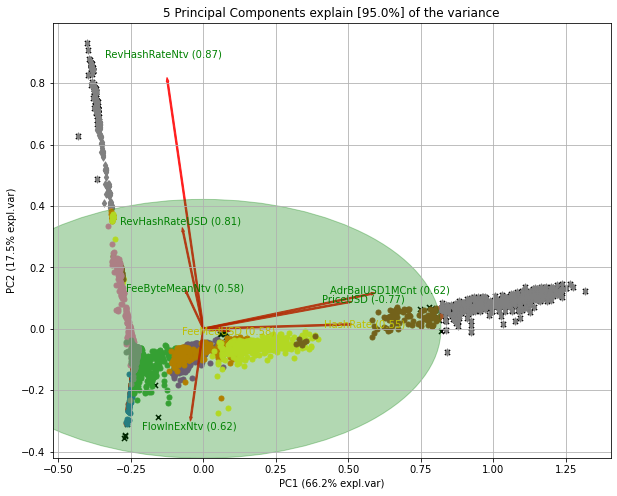

(<Figure size 720x576 with 1 Axes>,
 <AxesSubplot:title={'center':'5 Principal Components explain [95.0%] of the variance'}, xlabel='PC1 (66.2% expl.var)', ylabel='PC2 (17.5% expl.var)'>)

In [28]:
model2 = pca()
# Fit transform
out = model2.fit_transform(df_with_out)
model2.biplot(legend=False, SPE=True, hotellingt2=True, label = False)

### Mejores componentes del modelo sin valores atípicos multivariados 

In [29]:
print(out['topfeat'])

    PC         feature   loading  type
0  PC1  AdrBalUSD1MCnt  0.622942  best
1  PC2  RevHashRateNtv  0.865523  best
2  PC3     FlowInExNtv  0.619226  best
3  PC4     FlowInExNtv  0.665759  best
4  PC5  FeeByteMeanNtv  0.581946  best
5  PC6  RevHashRateUSD  0.805582  best
6  PC7  FeeByteMeanNtv  0.697289  best
7  PC8        PriceUSD -0.772746  best
8  PC5       FeeMedUSD  0.579673  weak
9  PC4        HashRate  0.548077  weak


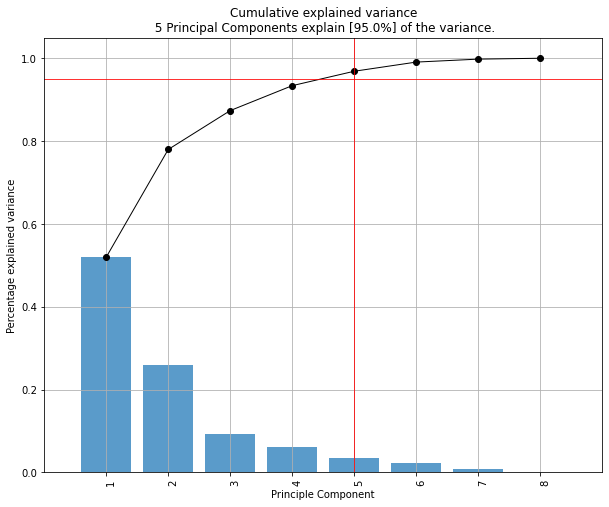

(<Figure size 720x576 with 1 Axes>,
 <AxesSubplot:title={'center':'Cumulative explained variance\n 5 Principal Components explain [95.0%] of the variance.'}, xlabel='Principle Component', ylabel='Percentage explained variance'>)

<Figure size 1440x720 with 0 Axes>

In [30]:
model.plot()

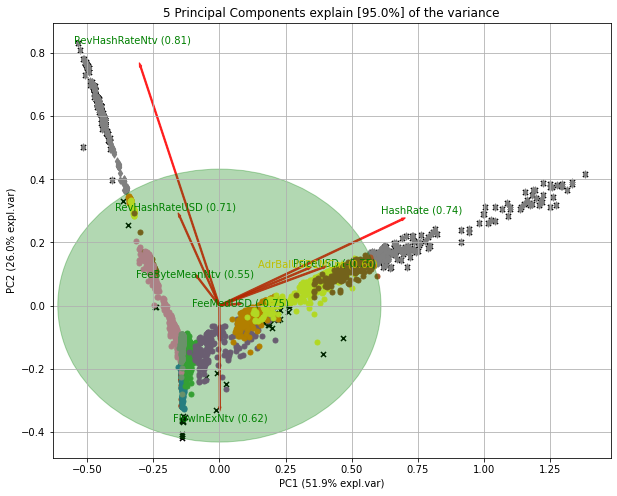

(<Figure size 720x576 with 1 Axes>,
 <AxesSubplot:title={'center':'5 Principal Components explain [95.0%] of the variance'}, xlabel='PC1 (51.9% expl.var)', ylabel='PC2 (26.0% expl.var)'>)

In [31]:
model.biplot(legend=False, SPE=True, hotellingt2=True, label = False)

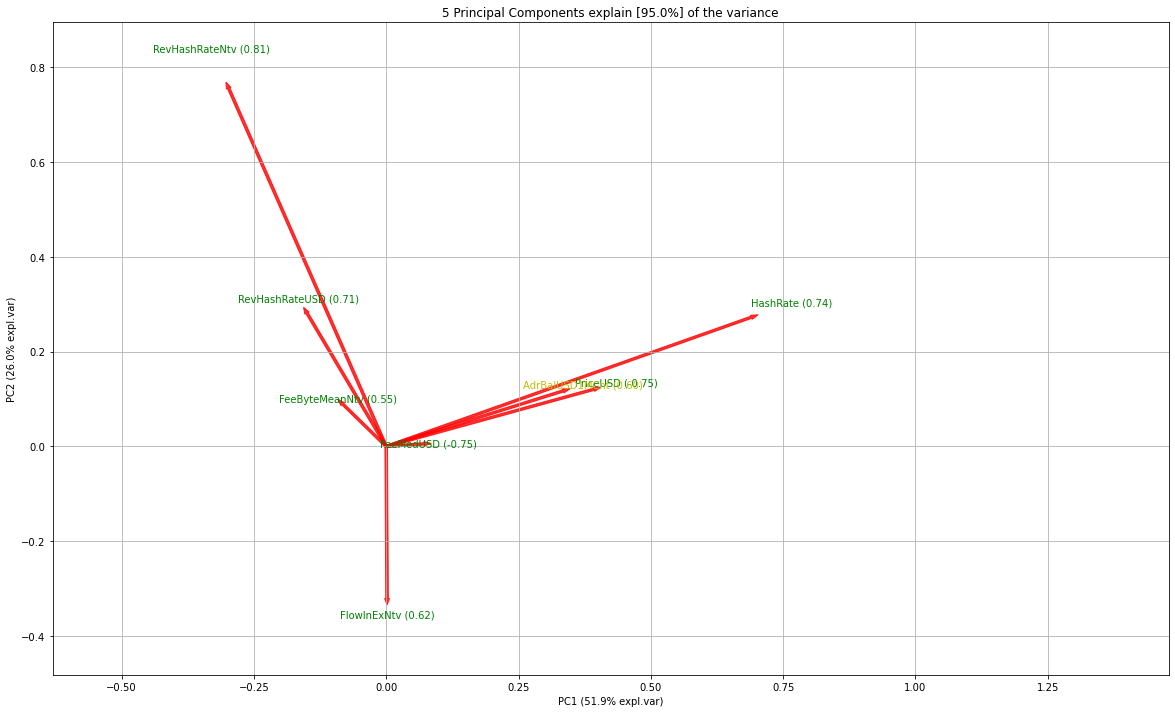

(<Figure size 1440x864 with 1 Axes>,
 <AxesSubplot:title={'center':'5 Principal Components explain [95.0%] of the variance'}, xlabel='PC1 (51.9% expl.var)', ylabel='PC2 (26.0% expl.var)'>)

In [32]:
model.biplot(cmap=None, label=False, legend=False,figsize=(20,12),visible=True)

### Eliminación de variables tomando en cuenta el peso y dirección de la variable PriceUSD

Se eliminan aquellos componentes que no estén en la misma dirección ni tengan un peso mayor o igual al de la variable precio

['AdrBalUSD1MCnt' 'FeeByteMeanNtv' 'FeeMedUSD' 'FlowInExNtv' 'HashRate'
 'RevHashRateNtv' 'RevHashRateUSD' 'PriceUSD']
PriceUSD


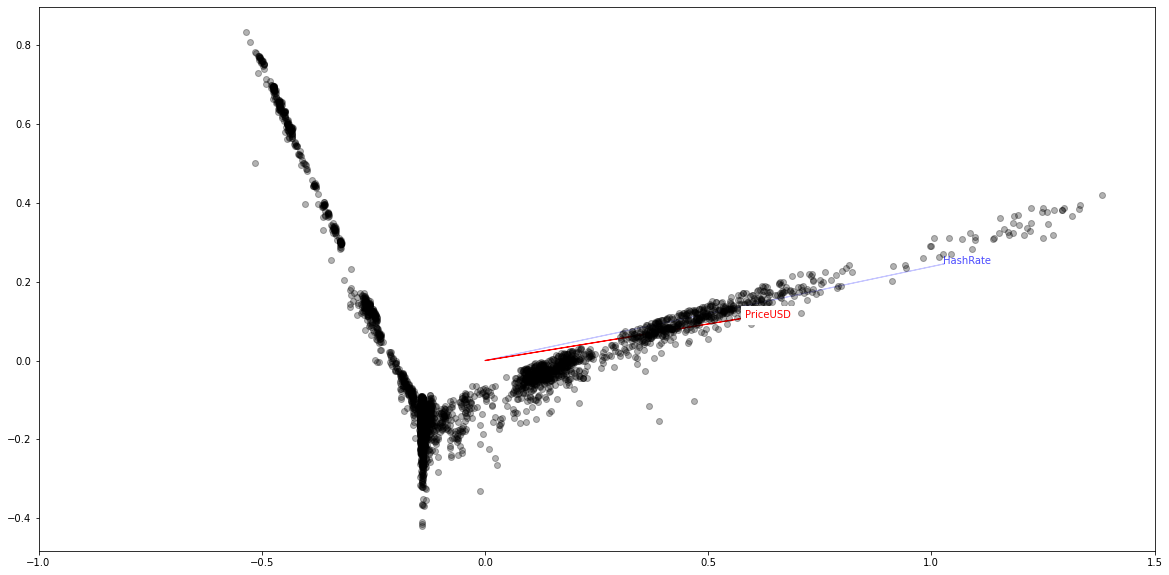

array(['HashRate', 'PriceUSD'], dtype=object)

In [35]:
from sklearn.decomposition import PCA

n = len(df_regresion_wo.columns)

pca = PCA(n_components = n)
pca.fit(df_regresion_wo)
xvector = pca.components_[0]
yvector = pca.components_[1]
xs = pca.transform(df_regresion_wo)[:,0]
ys = pca.transform(df_regresion_wo)[:,1]

print(df_regresion_wo.columns.values) #vector PriceUSD
print(df_regresion_wo.columns[-1])
plt.xlim(-1,1.5)
lim = np.sqrt(xvector[-1]**2 + yvector[-1]**2)
feat = []

for i in range(len(xvector)):
    if((np.sqrt(xvector[i]**2 + yvector[i]**2) >= lim) and ((np.sign(xvector[i]) == np.sign(xvector[-1])) and (np.sign(yvector[i]) == np.sign(yvector[-1])))):
        if(df_regresion_wo.columns[i] != "PriceUSD"):
            plt.arrow(0, 0, xvector[i]*max(xs), yvector[i]*max(ys),
                    color='b', width=0.0005, head_width=0.0025, alpha = 0.2)
            plt.text(xvector[i]*max(xs)*1, yvector[i]*max(ys)*1,
                    list(df_regresion_wo.columns.values)[i], color='b', alpha = 0.7)
        else:
            plt.arrow(0, 0, xvector[i]*max(xs), yvector[i]*max(ys),
                    color='r', width=0.0005, head_width=0.0025)
            plt.text(xvector[i]*max(xs)*1, yvector[i]*max(ys)*1,
                    list(df_regresion_wo.columns.values)[i], color='r', bbox = dict(facecolor='white', color="w"))
        feat.append(i)

for i in range(len(xs)):
    plt.plot(xs[i], ys[i], 'bo', color="k", alpha=0.3)

plt.show()
df_regresion_wo.columns.values[feat]

#### Creación de dataframe con varibales obtenidas en PCA

Total de **variables restantes 6**

In [36]:
df_red = df_regresion_wo[df_regresion_wo.columns.values[feat]].copy()
display(df_red)

,HashRate,PriceUSD
0,1.073670e-08,0.000044
1,1.218393e-08,0.000043
2,7.693048e-09,0.000037
3,9.261196e-09,0.000032
4,5.732863e-09,0.000037
...,...,...
3270,7.041420e-01,0.875824
3271,9.053254e-01,0.928684
3272,8.875740e-01,0.980405
3273,9.467456e-01,0.968685


In [37]:
#btc = db[df_red.columns.values[feat]].copy()
btc = pd.DataFrame(data=db, columns = df_red.columns.values)
btc.tail(5)
btc.to_csv('cleaning/BTC-coinMetrics.csv', encoding='utf-8', index=True)

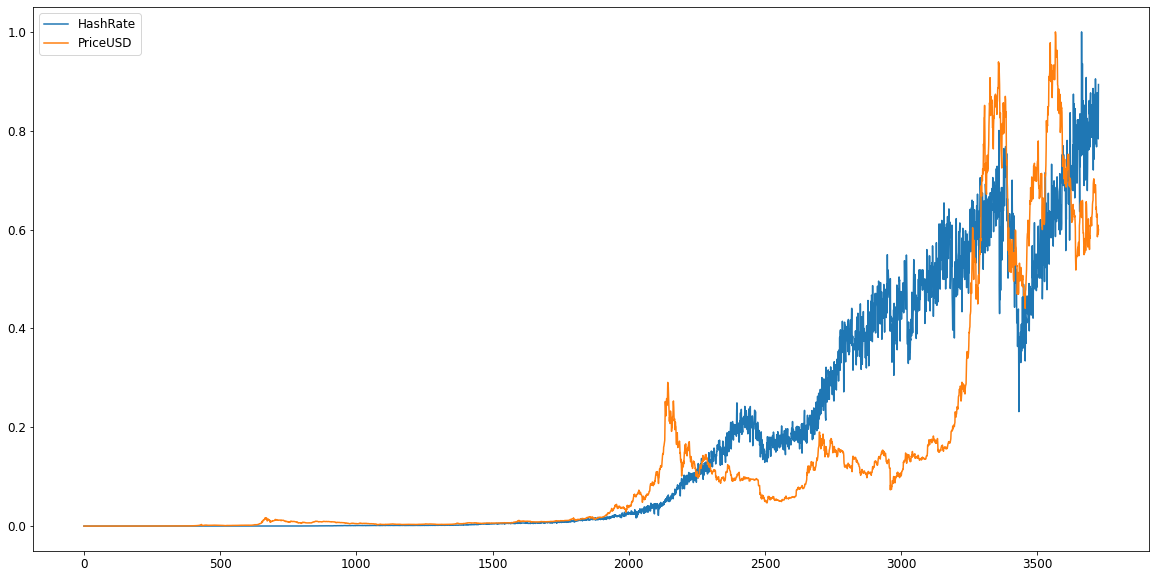

In [45]:
min_max_scaler = preprocessing.MinMaxScaler()
plt.plot(pd.DataFrame(min_max_scaler.fit_transform(btc)))
plt.legend(btc)
plt.show()

## Tabla de correlación de las variables

In [38]:
import dcor
distcorr = lambda column1, column2: dcor.distance_correlation(column1, column2) 
rslt = df_red.apply(lambda col1: df_red.apply(lambda col2: distcorr(col1, col2)))
pd.options.display.float_format = '{:,.2f}'.format
rslt

,HashRate,PriceUSD
HashRate,1.00,0.86
PriceUSD,0.86,1.00


## Dendograma de correlación entre variables.


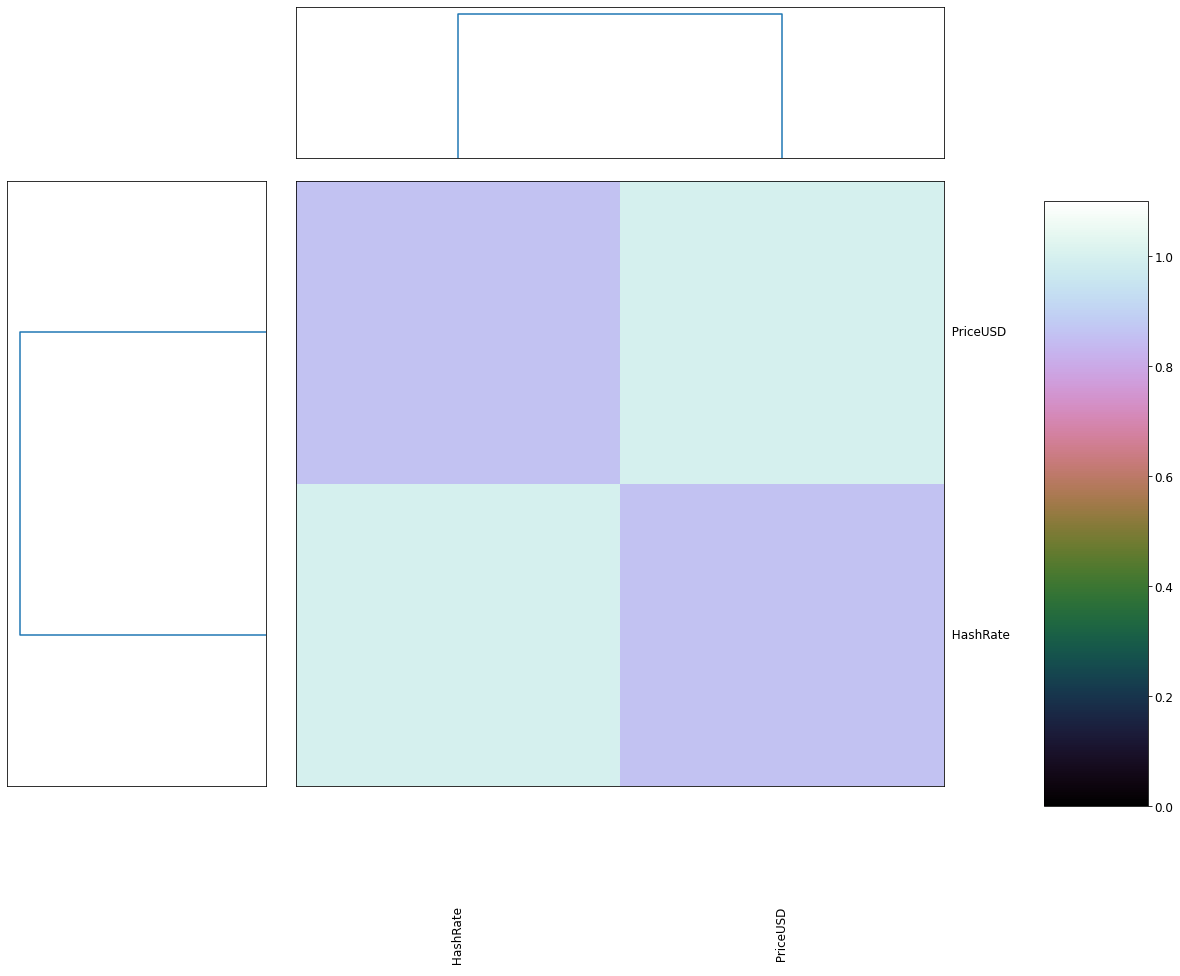

In [40]:
import dcor
from biokit.viz import heatmap

dist_corr = lambda column1, column2: dcor.distance_correlation(column1, column2)
rslt = df_red.apply(lambda col1: df_red.apply(lambda col2: dist_corr(col1, col2)))
h = heatmap.Heatmap(rslt)
h.plot(vmin=0.0, vmax=1.1, cmap='cubehelix',colorbar=True)
fig = plt.gcf()
fig.set_size_inches(18, 14)
plt.gcf().get_axes()[1].invert_xaxis();
plt.savefig('BTC_dendograma.png', dpi = 200)

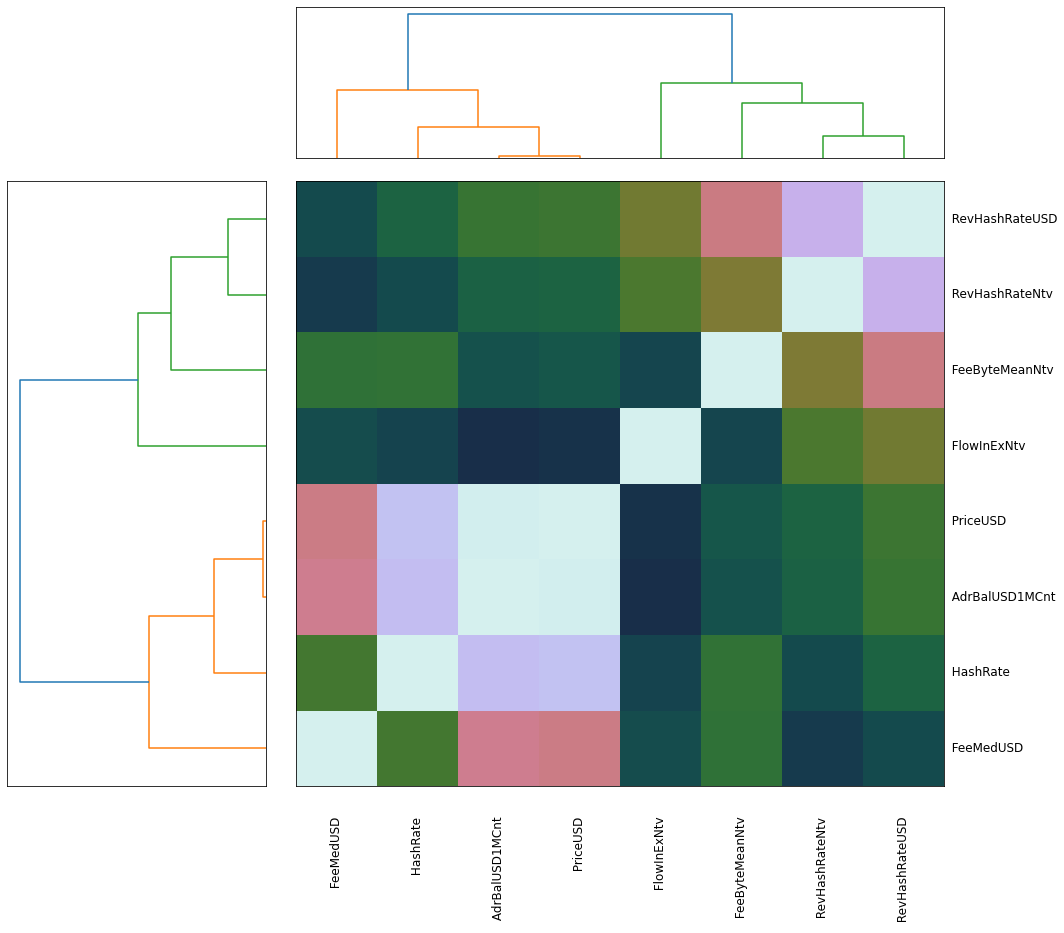

In [47]:
dist_corr = lambda column1, column2: dcor.distance_correlation(column1, column2)
rslt = df_regresion_wo.apply(lambda col1: df_regresion_wo.apply(lambda col2: dist_corr(col1, col2)))
h = heatmap.Heatmap(rslt)
h.plot(vmin=0.0, vmax=1.1, cmap='cubehelix',colorbar=False)
fig = plt.gcf()
fig.set_size_inches(18, 14)
plt.gcf().get_axes()[1].invert_xaxis();

In [60]:
# FeeMedUSD no se incluye ya que es una variable dependiente del precio
plot_metrics_btc = pd.DataFrame(data=db, columns = ["PriceUSD","HashRate","AdrBalUSD1MCnt"])
plot_metrics_btc.to_csv('cleaning/BTC-coinMetricsV2.csv', encoding='utf-8', index=True)

Guardar datos sin normalizar

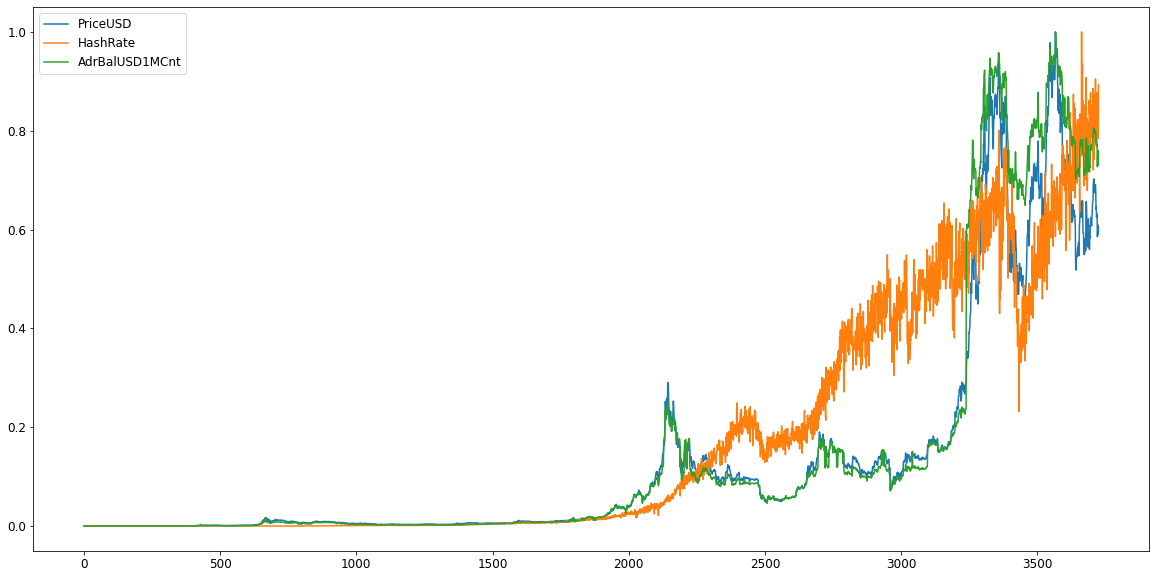

In [62]:
min_max_scaler = preprocessing.MinMaxScaler()
plot_metrics = pd.DataFrame(min_max_scaler.fit_transform(plot_metrics_btc))

plt.plot(plot_metrics)
plt.legend(plot_metrics_btc)
plt.show()